In [1]:
import numpy as np
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from ripser import ripser
from persim import plot_diagrams as plot_dgms
from dreimac import ProjectiveCoords, get_stereo_proj_codim1
import warnings
warnings.filterwarnings('ignore')


from torchvision import transforms
import torchvision
import torch
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def imscatter(X, P, dim, zoom=1):
    """
    Plot patches in specified locations in R2
    
    Parameters
    ----------
    X : ndarray (N, 2)
        The positions of each patch in R2
    P : ndarray (N, dim*dim)
        An array of all of the patches
    dim : int
        The dimension of each patch
    
    """
    #https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points
    ax = plt.gca()
    for i in range(P.shape[0]):
        patch = np.reshape(P[i, :], (dim, dim))
        x, y = X[i, :]
        im = OffsetImage(patch, zoom=zoom, cmap = 'gray')
        ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
        ax.add_artist(ab)
    ax.update_datalim(X)
    ax.autoscale()
    ax.set_xticks([])
    ax.set_yticks([])

def plotPatches(P, zoom = 1):
    """
    Plot patches in a best fitting rectangular grid
    """
    N = P.shape[0]
    
    d = int(np.sqrt(P.shape[1]))
    print(d)
    dgrid = int(np.ceil(np.sqrt(N)))
    ex = np.arange(dgrid)
    x, y = np.meshgrid(ex, ex)
    X = np.zeros((N, 2))
    X[:, 0] = x.flatten()[0:N]
    X[:, 1] = y.flatten()[0:N]
    imscatter(X, P, d, zoom)

def fft_img(img):
    #Output is a 2D complex array. 1st channel real and 2nd imaginary
    #For fft in opencv input image needs to be converted to float32
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

    #Rearranges a Fourier transform X by shifting the zero-frequency 
    #component to the center of the array.
    #Otherwise it starts at the tope left corenr of the image (array)
    dft_shift = np.fft.fftshift(dft)

    ##Magnitude of the function is 20.log(abs(f))
    #For values that are 0 we may end up with indeterminate values for log. 
    #So we can add 1 to the array to avoid seeing a warning. 
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])) +1


    # Circular HPF mask, center circle is 0, remaining all ones
    #Can be used for edge detection because low frequencies at center are blocked
    #and only high frequencies are allowed. Edges are high frequency components.
    #Amplifies noise.

    rows, cols = img.shape
    crow, ccol = int(rows / 2), int(cols / 2)

    mask = np.ones((rows, cols, 2), np.uint8)
    r = 6
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 >= r*r
    mask[mask_area] = 0

#     print(np.count_nonzero(mask))


    # apply mask and inverse DFT
    fshift = dft_shift * mask

    fshift_mask_mag = 2000 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))

    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

    return img_back, fshift_mask_mag

In [3]:
class TransformFFTLowPass(object):
    """ the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size=9):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        return sample


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

(400, 784)
28


<IPython.core.display.Javascript object>


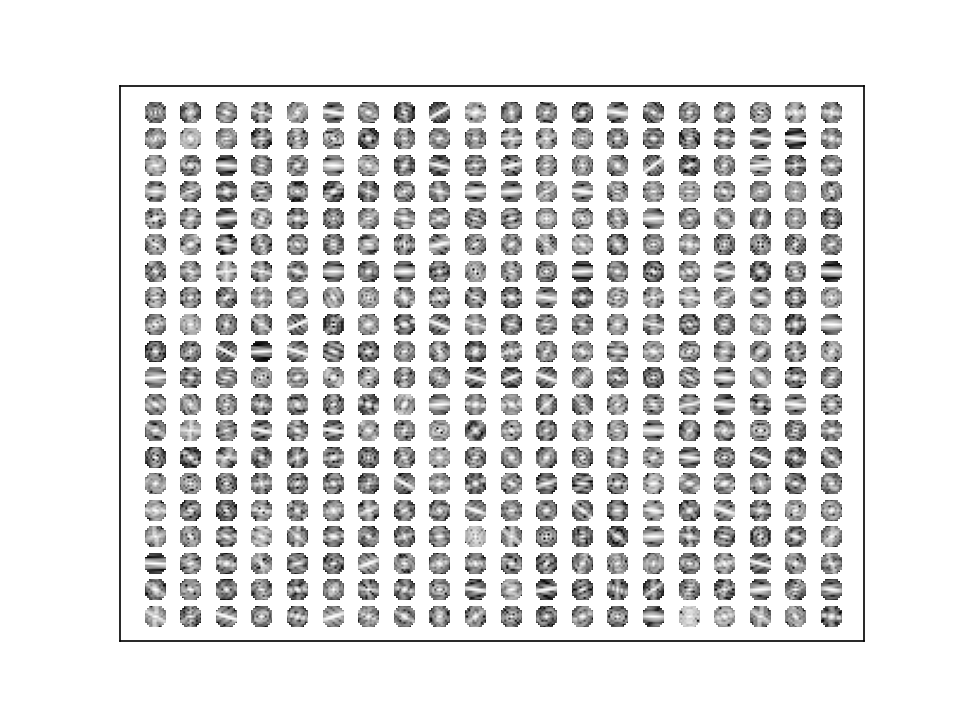

In [4]:
batch_size=10
mean=0.1307
std=0.3081
size=50
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     TransformFFTLowPass(),
#      transforms.Resize(size),
     # transforms.Grayscale(num_output_channels=1),
     transforms.RandomHorizontalFlip(p=0.5)])


trainset = torchvision.datasets.MNIST(root='./data', train=False,
#                                        split='letters',
                                      download=True, transform=transform_train)


import numpy as np
P = trainset[0][0].detach().to("cpu").numpy()
np.shape(P)
for i in range(1,400):
    P = np.vstack((P,trainset[i][0].detach().to("cpu").numpy()))

Q = np.zeros((P.shape[0],P.shape[1]*P.shape[2]))
for i in range(400):
    img=P[i,:,:]
    _, lpf = fft_img(img)
    Q[i,:] = lpf.flatten()

print(Q.shape)

plotPatches(Q,zoom=1)